## Using Linear Regession for Market Movement Prediction

In [1]:
import os
import random
import numpy as np
import pandas as pd
from pylab import mpl, plt
import pandas_datareader.data as web
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASSEED'] = '0'

In [2]:
x = np.linspace(0,10)

def set_seed(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
set_seed()

In [3]:
y = x + np.random.standard_normal(len(x))

In [4]:
reg = np.polyfit(x,y,deg=1)
reg

array([0.94612934, 0.22855261])

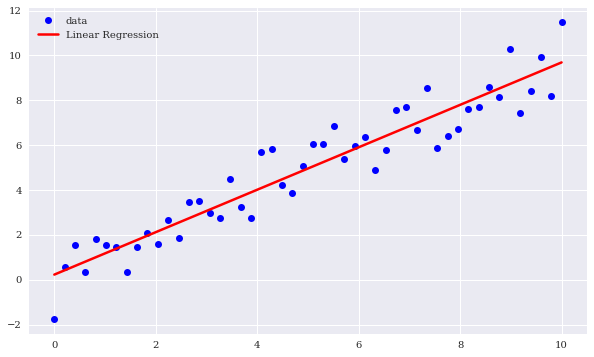

In [5]:
plt.figure(figsize=(10,6))
plt.plot(x,y,'bo',label = 'data')

plt.plot(x,np.polyval(reg,x),'r',lw=2.5, label='Linear Regression')
plt.legend(loc=0)

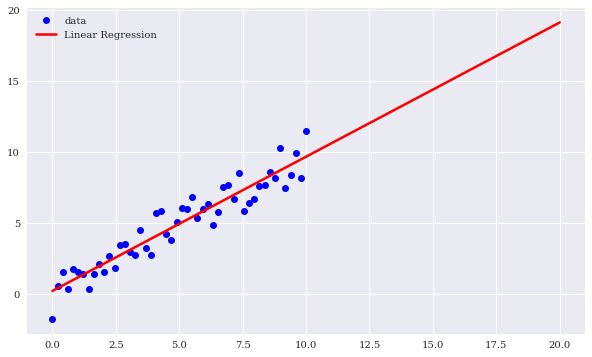

In [6]:
plt.figure(figsize=(10,6))
plt.plot(x,y,'bo',label = 'data')
xn = np.linspace(0,20)
plt.plot(xn,np.polyval(reg,xn),'r',lw=2.5, label='Linear Regression')
plt.legend(loc=0)

## The Basic Idea for price Predictions

In [7]:
x = np.arange(12)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [8]:
lags = 3
m = np.zeros((lags+1, len(x)-lags))

m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i:i - lags]
m.T

array([[ 0.,  1.,  2.,  3.],
       [ 1.,  2.,  3.,  4.],
       [ 2.,  3.,  4.,  5.],
       [ 3.,  4.,  5.,  6.],
       [ 4.,  5.,  6.,  7.],
       [ 5.,  6.,  7.,  8.],
       [ 6.,  7.,  8.,  9.],
       [ 7.,  8.,  9., 10.],
       [ 8.,  9., 10., 11.]])

In [9]:
m

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]])

In [10]:
reg = np.linalg.lstsq(m[:lags].T, m[lags], rcond = None)[0]

In [11]:
reg

array([-0.66666667,  0.33333333,  1.33333333])

In [12]:
np.dot(m[:lags].T,reg)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [13]:
data = web.DataReader('WIPRO.NS', 'yahoo', '2016-01-01','2022-09-30')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1652 entries, 2016-01-01 to 2022-09-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1652 non-null   float64
 1   Low        1652 non-null   float64
 2   Open       1652 non-null   float64
 3   Close      1652 non-null   float64
 4   Volume     1652 non-null   float64
 5   Adj Close  1652 non-null   float64
dtypes: float64(6)
memory usage: 90.3 KB


In [15]:
lags = 5
cols = []

for lag in range(1, lags+1):
    col = f'lag_{lag}'
    data[col] = data['Close'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

reg = np.linalg.lstsq(data[cols],data['Close'], rcond=None)[0]

In [16]:
reg

array([ 1.05031231, -0.07836358,  0.07572929, -0.02039394, -0.02714185])

<AxesSubplot:xlabel='Date'>

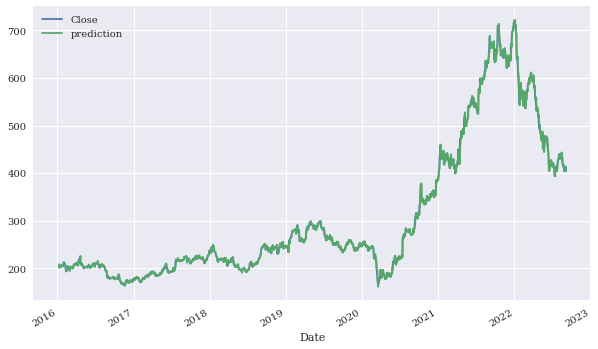

In [17]:
data['prediction'] = np.dot(data[cols],reg)
data[['Close','prediction']].plot(figsize=(10,6))

<AxesSubplot:xlabel='Date'>

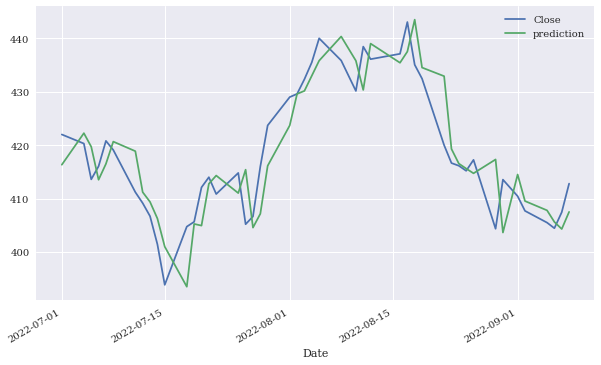

In [18]:
data[['Close','prediction']].loc['2022-07-01':].plot(figsize=(10,6))

In [19]:
data['return'] = np.log(data['Close']/data['Close'].shift(1))
data.dropna(inplace=True)

cols = []
for lag in range(1, lags+1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [20]:
reg = np.linalg.lstsq(data[cols], data['return'],rcond=None)[0]

In [21]:
reg

array([-0.00488214,  0.01682004,  0.03901613, -0.00131559,  0.03369734])

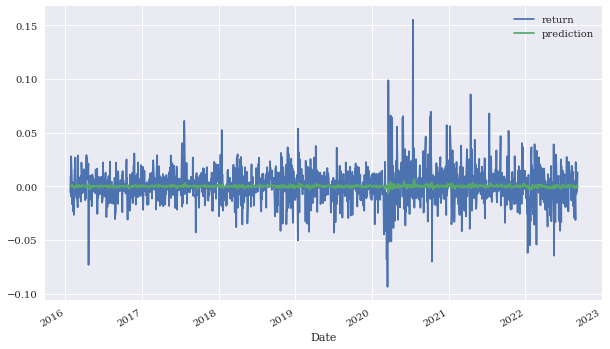

In [22]:
data['prediction'] = np.dot(data[cols],reg)
data[['return','prediction']].iloc[lags:].plot(figsize=(10,6));

In [23]:
hits = np.sign(data['return']*data['prediction']).value_counts()
hits

 1.0    859
-1.0    775
 0.0      7
dtype: int64

In [24]:
hits.values[0]/sum(hits)

0.5234613040828763

## predicting Future Market Direction

In [25]:
reg = np.linalg.lstsq(data[cols], np.sign(data['return']), rcond = None)[0]
reg

array([ 0.55750428,  0.52721153,  2.83251455, -0.46149952,  1.27488462])

In [26]:
data['prediction'] = np.sign(np.dot(data[cols], reg))
data['prediction'].value_counts()

 1.0    851
-1.0    790
Name: prediction, dtype: int64

In [27]:
hits = np.sign(data['return']*data['prediction']).value_counts()
hits

 1.0    841
-1.0    793
 0.0      7
dtype: int64

In [28]:
hits.values[0]/sum(hits)

0.5124923826934796

## Vecortized Backtesting of Regression - Based Strategy

In [29]:
data.head()

,High,Low,Open,Close,Volume,Adj Close,lag_1,lag_2,lag_3,lag_4,lag_5,prediction,return
Date,,,,,,,,,,,,,
2016-01-18,206.550049,199.031296,201.375046,205.181305,4515961.0,197.613754,-0.003951,-0.002290,-0.004382,0.021081,-0.033573,-1.0,0.007430
2016-01-19,207.000046,201.750046,205.500046,203.250046,2553140.0,195.753708,0.007430,-0.003951,-0.002290,-0.004382,0.021081,1.0,-0.009457
2016-01-20,206.962555,199.950043,202.143799,203.456299,3119055.0,195.952362,-0.009457,0.007430,-0.003951,-0.002290,-0.004382,-1.0,0.001014
2016-01-21,208.125046,203.081299,203.081299,206.550049,4650132.0,198.931992,0.001014,-0.009457,0.007430,-0.003951,-0.002290,1.0,0.015092
2016-01-22,208.387558,205.162552,208.387558,206.287552,2222631.0,198.679199,0.015092,0.001014,-0.009457,0.007430,-0.003951,-1.0,-0.001272


In [30]:
data['strategy'] = data['prediction']*data['return']

In [31]:
data[['return', 'strategy']].sum().apply(np.exp)

return      2.026882
strategy    1.386946
dtype: float64

<AxesSubplot:xlabel='Date'>

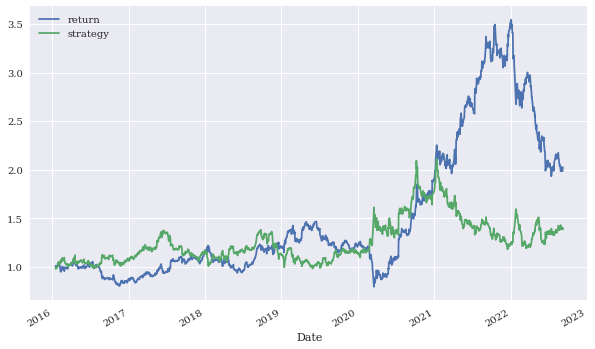

In [32]:
data[['return', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10,6))

# Using Machine Learning for Market Movement Prediction

In [37]:
x = np.arange(12)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [40]:
lags = 3
m = np.zeros((lags + 1, len(x)-lags))
m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i:i - lags]

In [42]:
# pip install sklearn

In [44]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
lm.fit(m[:lags].T, m[lags])


LinearRegression()

In [45]:
lm.coef_

array([0.33333333, 0.33333333, 0.33333333])

In [46]:
lm.intercept_

2.0

In [48]:
lm.predict(m[:lags].T)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [49]:
lm = linear_model.LinearRegression(fit_intercept=False)
lm.fit(m[:lags].T, m[lags])

LinearRegression(fit_intercept=False)

In [50]:
lm.coef_

array([-0.66666667,  0.33333333,  1.33333333])

In [51]:
lm.intercept_

0.0

In [52]:
lm.predict(m[:lags].T)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])